In [1]:
# !pip install pandas transformers scikit-learn matplotlib seaborn sentencepiece accelerate -q
# !pip install protobuf

# import pandas as pd
# hate_yes_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_yes.csv')
# hate_no_data = pd.read_csv('/root/ccs_aisf/data/yes_no/hate_vs_antagonist_no.csv')

# torch.set_default_tensor_type(torch.cuda.HalfTensor)

## **1. Datasets.**

In [2]:
import re
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
# from transformers import EncoderDecoderModel, BertTokenizer, DistilBertTokenizer
# from transformers import AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm

import sys
import os

# Add the code directory directly to Python path
code_dir = '/Users/elenaericheva/ericheva_git/ccs_aisf/code'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

print(f"Added {code_dir} to Python path")

/Users/elenaericheva/ericheva_git/ccs_aisf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Added /Users/elenaericheva/ericheva_git/ccs_aisf/code to Python path


## **2. Choose model.**

In [3]:
# Available Gemma2 variants:

# google/gemma-2-2b - 2B parameter base model
# google/gemma-2-9b - 9B parameter base model
# google/gemma-2-2b-it - 2B instruction-tuned model
# google/gemma-2-9b-it - 9B instruction-tuned model

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

YOUR_NAME = "gemma-2-9b"

# CHANGED: Using Gemma2 model instead of DeBERTa
# IMPORTANT: Must use AutoModelForCausalLM, NOT AutoModelForMaskedLM
gemma_tokenizer = AutoTokenizer.from_pretrained(f"google/{YOUR_NAME}")
gemma_model = AutoModelForCausalLM.from_pretrained(
    f"google/{YOUR_NAME}",
    torch_dtype=torch.float32,  # Use half precision for efficiency
    device_map="auto"           # Automatically map to available GPUs
)

gemma_model.eval();
LAYER_IDX = 18


Loading checkpoint shards: 100%|██████████| 8/8 [00:14<00:00,  1.86s/it]
Some parameters are on the meta device because they were offloaded to the disk.


## **4. Plot.**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import combinations
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

Extracting embeddings (strategy: last-token): 100%|██████████| 1244/1244 [2:21:36<00:00,  6.83s/it] 


Extraction completed: shape=(1244, 43, 3584), dtype=float32
Stats: max=660.767, min=-391.058, std=5.549


Extracting embeddings (strategy: last-token): 100%|██████████| 1244/1244 [2:33:53<00:00,  7.42s/it] 


Extraction completed: shape=(1244, 43, 3584), dtype=float32
Stats: max=712.028, min=-345.419, std=5.327
X_pos dtype: float32
X_pos shape: (1244, 43, 3584)
X_neg dtype: float32
X_neg shape: (1244, 43, 3584)
######################################################################################## 
X_pos.max() 660.76697
X_pos.min() -391.05847
X_pos.mean() -0.116078354
X_pos.std() 5.549439
X_pos.median() -0.024239115
X_neg.max() 712.0284
X_neg.min() -345.41943
X_neg.mean() -0.11764855
X_neg.std() 5.3270636
X_neg.median() -0.035106763
######################################################################################## 
X_pos sample: [-0.70312655 -1.8004283  -1.0341221  -0.16389246 -0.05925955]
X_neg sample: [-0.70312655 -1.8004283  -1.0341221  -0.16389246 -0.05925955]
Normalization completed!
X_pos_normalized shape: (1244, 43, 3584)
X_neg_normalized shape: (1244, 43, 3584)
X_pos_normalized dtype: float32
X_pos_normalized shape: (1244, 43, 3584)
X_neg_normalized dtype: float32
X_neg_norma

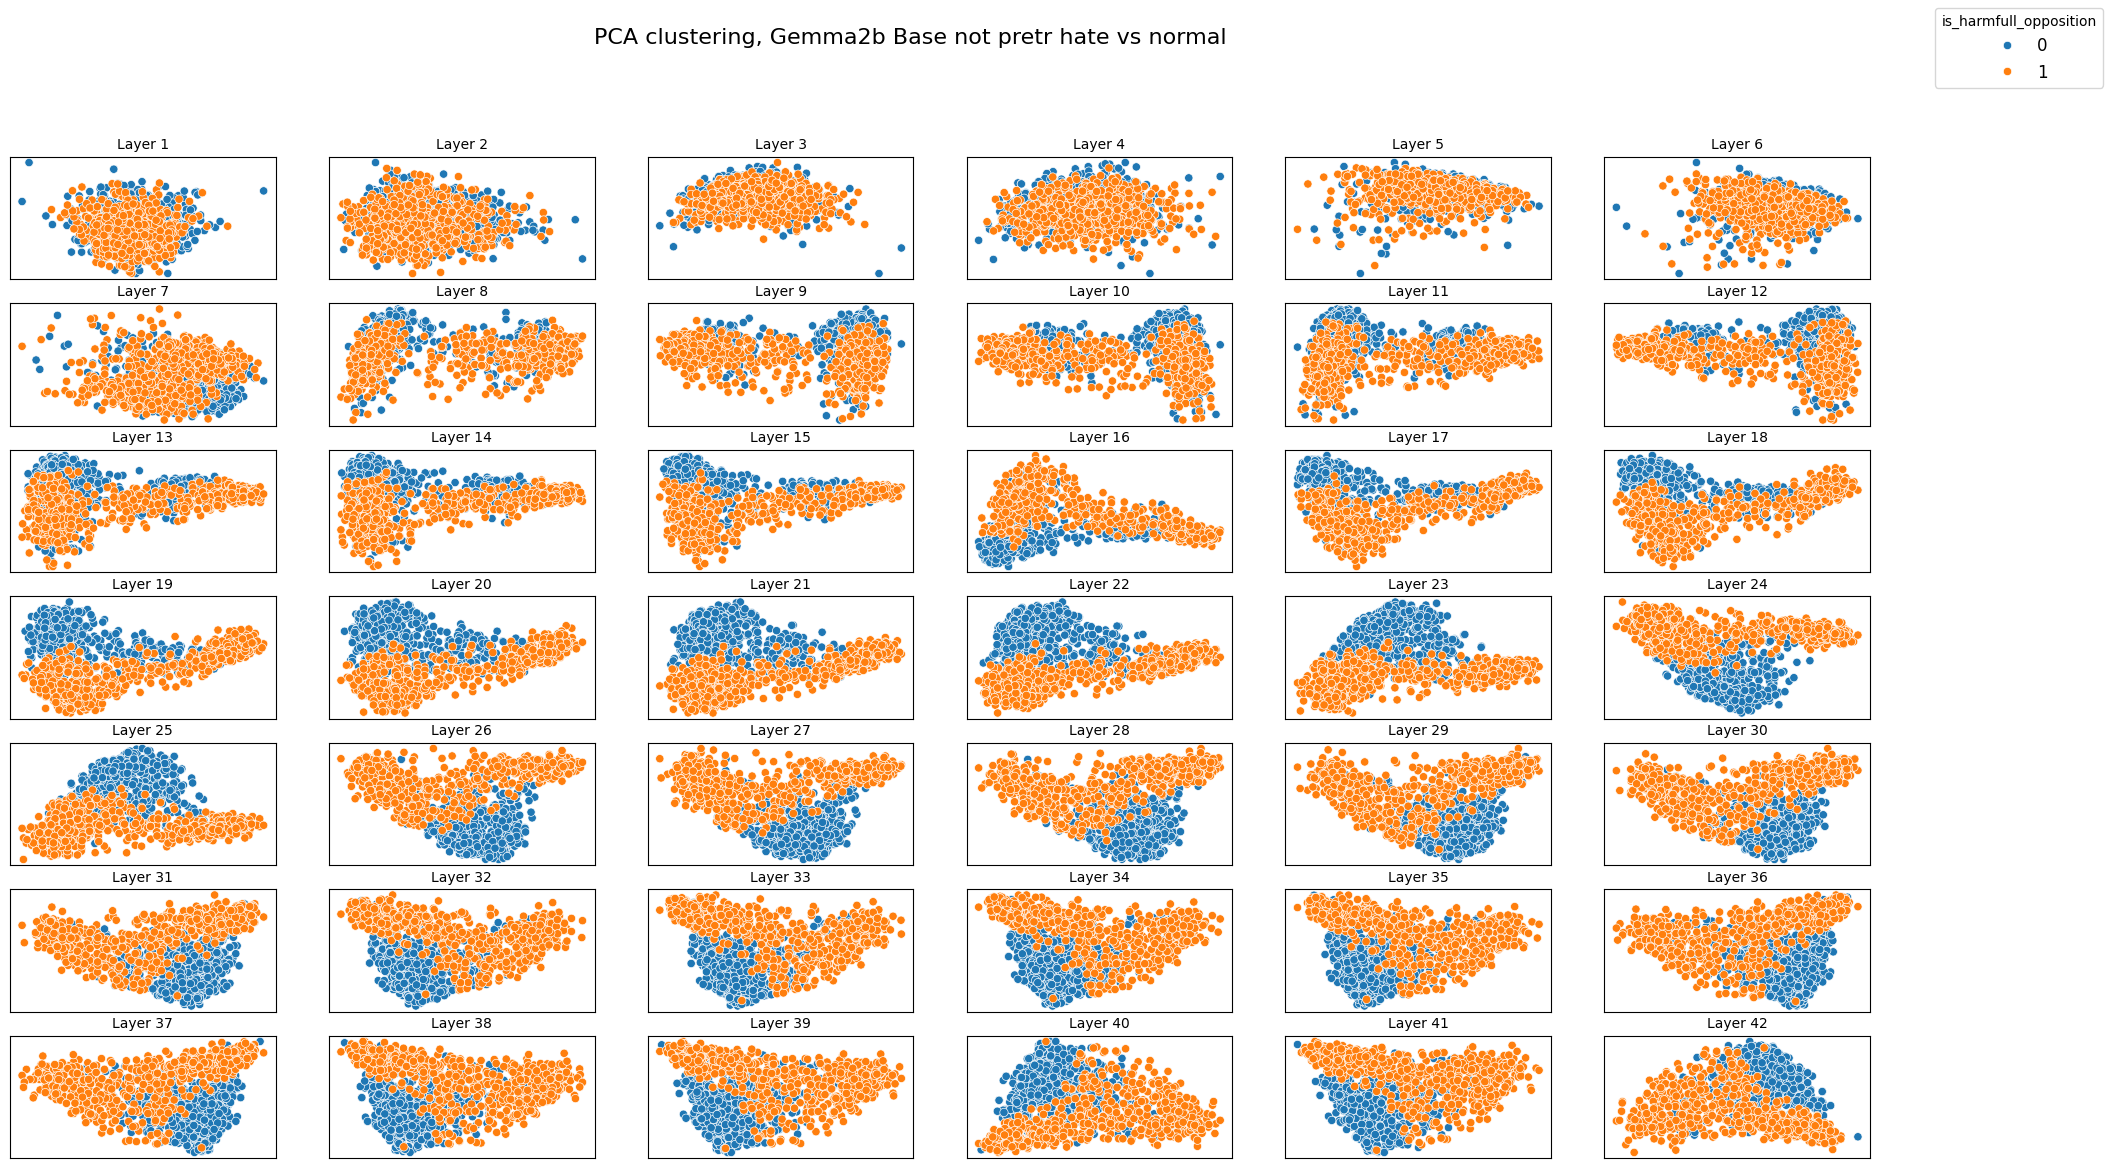

In [5]:
# path to big hate data
hate_data = pd.read_csv('../data/raw/total_hate_data.csv', index_col=0)
hate_data.head(2)

hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total_yes_data.csv', index_col=0)
hate_total_no_data =  pd.read_csv('../data/yes_no/hate_total_no_data.csv', index_col=0)

from extract_fixed import vectorize_df, extract_representation

X_pos = vectorize_df(hate_total_yes_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

X_neg = vectorize_df(hate_total_no_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

import numpy as np

np.savez_compressed(f'{YOUR_NAME}_neg.npz', X_neg)
np.savez_compressed(f'{YOUR_NAME}_pos.npz', X_pos)

# Load the files correctly
X_pos_file = np.load(f'{YOUR_NAME}_pos.npz')
X_neg_file = np.load(f'{YOUR_NAME}_neg.npz')

# Extract the actual arrays
X_pos = X_pos_file['arr_0']
X_neg = X_neg_file['arr_0']

# Check data types and shapes first
print("X_pos dtype:", X_pos.dtype)
print("X_pos shape:", X_pos.shape)
print("X_neg dtype:", X_neg.dtype)
print("X_neg shape:", X_neg.shape)

print("######################################################################################## ")
print("X_pos.max()", X_pos.max())
print("X_pos.min()", X_pos.min())
print("X_pos.mean()", X_pos.mean())
print("X_pos.std()", X_pos.std())
print("X_pos.median()", np.median(X_pos))
print("X_neg.max()", X_neg.max())
print("X_neg.min()", X_neg.min())
print("X_neg.mean()", X_neg.mean())
print("X_neg.std()", X_neg.std())
print("X_neg.median()", np.median(X_neg))
print("######################################################################################## ")

# Check for any issues with the data
print("X_pos sample:", X_pos.flat[:5])
print("X_neg sample:", X_neg.flat[:5])

# Convert to proper numeric type if needed
X_pos = X_pos.astype(np.float32)
X_neg = X_neg.astype(np.float32)

n_samples, n_layers, n_features = X_pos.shape

# Normalize the data
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)

print("Normalization completed!")
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized shape:", X_neg_normalized.shape)

# Check data types and shapes first
print("X_pos_normalized dtype:", X_pos_normalized.dtype)
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized dtype:", X_neg_normalized.dtype)
print("X_neg_normalized shape:", X_neg_normalized.shape)

print("######################################################################################## ")
print("X_pos_normalized.max()", X_pos_normalized.max())
print("X_pos_normalized.min()", X_pos_normalized.min())
print("X_pos_normalized.mean()", X_pos_normalized.mean())
print("X_pos_normalized.std()", X_pos_normalized.std())
print("X_pos_normalized.median()", np.median(X_pos_normalized))
print("X_neg_normalized.max()", X_neg_normalized.max())
print("X_neg_normalized.min()", X_neg_normalized.min())
print("X_neg_normalized.mean()", X_neg_normalized.mean())
print("X_neg_normalized.std()", X_neg_normalized.std())
print("X_neg_normalized.median()", np.median(X_neg_normalized))
print("######################################################################################## ")

# Verify normalization worked - check L2 norms
print("X_pos_normalized sample norms:", np.linalg.norm(X_pos_normalized.reshape(-1, n_features)[:5], axis=1))
print("X_neg_normalized sample norms:", np.linalg.norm(X_neg_normalized.reshape(-1, n_features)[:5], axis=1))

# Plot PCA
from format_results_fixed import plot_pca_or_tsne_layerwise
plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, Gemma2b Base not pretr hate vs normal')

## **5. Find best CCS**


To find the best layers, train CCS on all hidden states. You can use different normalization strategies, the best in experiments was l2 + median.

Median normalize used
Layer 1/43, CCS accuracy: 0.5381526104417671
Median normalize used
Layer 2/43, CCS accuracy: 0.5421686746987953
Median normalize used
Layer 3/43, CCS accuracy: 0.5943775100401607
Median normalize used
Layer 4/43, CCS accuracy: 0.6305220883534136
Median normalize used
Layer 5/43, CCS accuracy: 0.642570281124498
Median normalize used
Layer 6/43, CCS accuracy: 0.6265060240963856
Median normalize used
Layer 7/43, CCS accuracy: 0.6305220883534137
Median normalize used
Layer 8/43, CCS accuracy: 0.678714859437751
Median normalize used
Layer 9/43, CCS accuracy: 0.6827309236947792
Median normalize used
Layer 10/43, CCS accuracy: 0.678714859437751
Median normalize used
Layer 11/43, CCS accuracy: 0.678714859437751
Median normalize used
Layer 12/43, CCS accuracy: 0.6827309236947792
Median normalize used
Layer 13/43, CCS accuracy: 0.678714859437751
Median normalize used
Layer 14/43, CCS accuracy: 0.678714859437751
Median normalize used
Layer 15/43, CCS accuracy: 0.674698795180

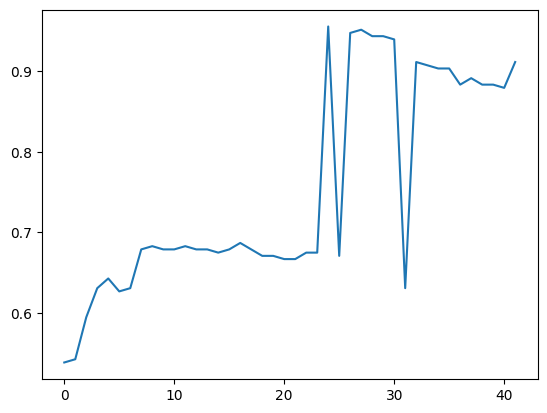

In [6]:
import random
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from ccs import CCS, train_ccs_on_hidden_states



SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')

with open(f'ccs_{YOUR_NAME}_mixed_data_results.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)

acc = []
for layer_idx in range(gemma_model.config.num_hidden_layers):
    acc.append(orig_ccs[layer_idx]['accuracy'])

plt.plot(acc)
plt.show()

LAYER_IDX = np.argmax(acc)


After that, we train the CCS on the selected layer to obtain the probe and its weights.

In [7]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random


X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])

# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=71, shuffle=True)


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

with open(f'ccs_{YOUR_NAME}_l_{LAYER_IDX}_mixed_data_results.pkl', 'wb') as f:
    pickle.dump(ccs, f)

ccs = pickle.load(open(f'ccs_{YOUR_NAME}_l_{LAYER_IDX}_mixed_data_results.pkl', 'rb'))

CCS accuracy: 0.8674698795180723


# NOT

Extracting embeddings: 100%|██████████| 1250/1250 [2:24:48<00:00,  6.95s/it] 


X_pos dtype: float32
X_pos shape: (1250, 43, 3584)
X_neg dtype: float32
X_neg shape: (1250, 43, 3584)
######################################################################################## 
X_pos.max() 671.1399
X_pos.min() -395.76202
X_pos.mean() -0.10206942
X_pos.std() 5.6108403
X_pos.median() -0.01660809
X_neg.max() 659.06525
X_neg.min() -347.84253
X_neg.mean() -0.10439921
X_neg.std() 5.2895737
X_neg.median() -0.031088468
######################################################################################## 
X_pos sample: [-0.70312655 -1.8004283  -1.0341221  -0.16389246 -0.05925955]
X_neg sample: [-0.70312655 -1.8004283  -1.0341221  -0.16389246 -0.05925955]
Normalization completed!
X_pos_normalized shape: (1250, 43, 3584)
X_neg_normalized shape: (1250, 43, 3584)
X_pos_normalized dtype: float32
X_pos_normalized shape: (1250, 43, 3584)
X_neg_normalized dtype: float32
X_neg_normalized shape: (1250, 43, 3584)
###########################################################################

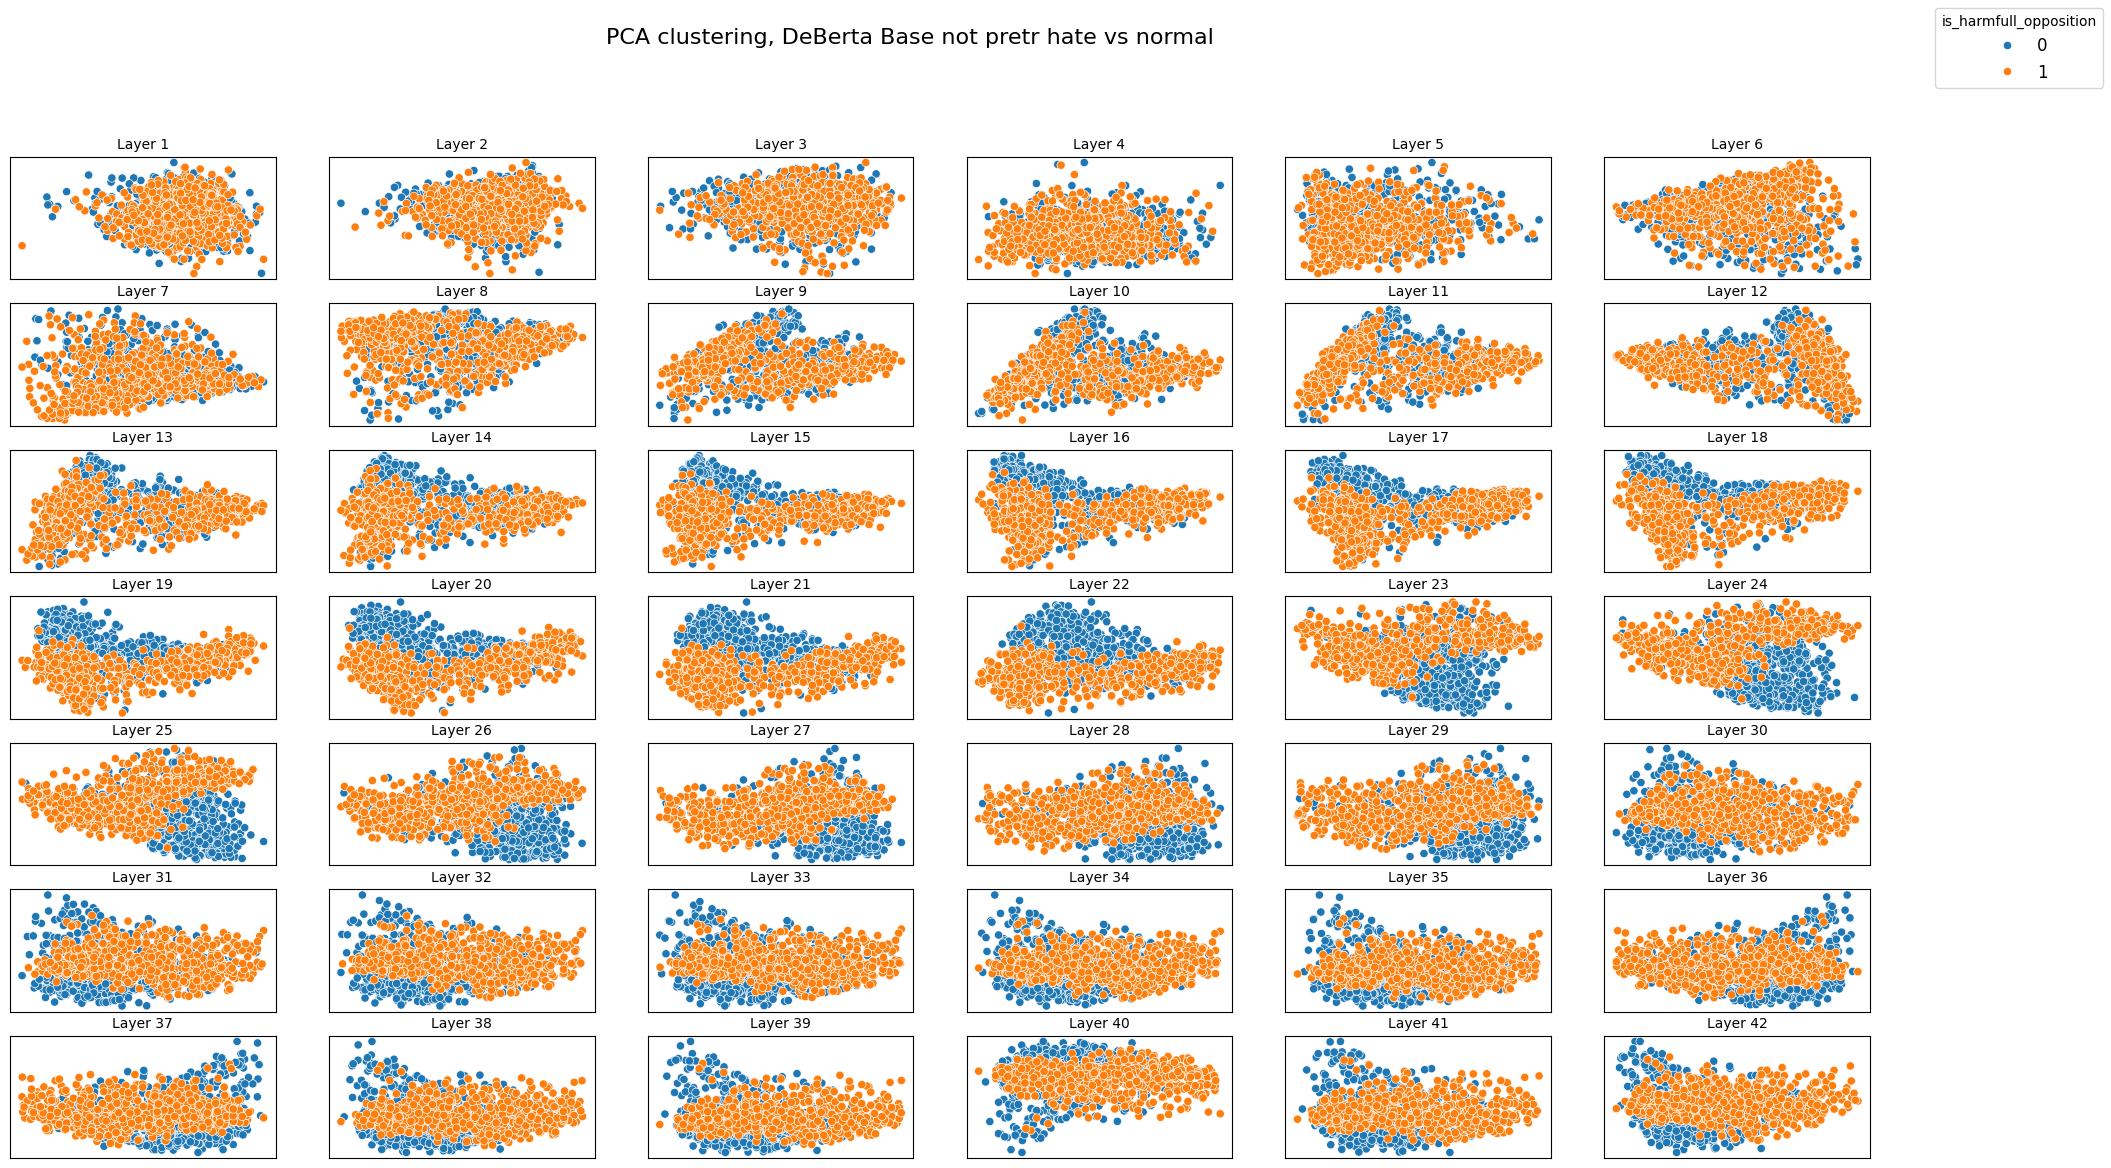

In [8]:
# path to big hate data
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
hate_data.head(2)

hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total3.0_yes.csv', index_col=0)
hate_total_no_data =  pd.read_csv('../data/yes_no/hate_total3.0_no.csv', index_col=0)



from extract import vectorize_df, extract_representation

X_pos = vectorize_df(hate_total_yes_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

X_neg = vectorize_df(hate_total_no_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

np.savez_compressed(f'{YOUR_NAME}_neg_not.npz', X_neg)
np.savez_compressed(f'{YOUR_NAME}_pos_not.npz', X_pos)

# Load the files correctly
X_pos_file = np.load(f'{YOUR_NAME}_pos_not.npz')
X_neg_file = np.load(f'{YOUR_NAME}_neg_not.npz')

# Extract the actual arrays
X_pos = X_pos_file['arr_0']
X_neg = X_neg_file['arr_0']




# Check data types and shapes first
print("X_pos dtype:", X_pos.dtype)
print("X_pos shape:", X_pos.shape)
print("X_neg dtype:", X_neg.dtype)
print("X_neg shape:", X_neg.shape)

print("######################################################################################## ")
print("X_pos.max()", X_pos.max())
print("X_pos.min()", X_pos.min())
print("X_pos.mean()", X_pos.mean())
print("X_pos.std()", X_pos.std())
print("X_pos.median()", np.median(X_pos))
print("X_neg.max()", X_neg.max())
print("X_neg.min()", X_neg.min())
print("X_neg.mean()", X_neg.mean())
print("X_neg.std()", X_neg.std())
print("X_neg.median()", np.median(X_neg))
print("######################################################################################## ")

# Check for any issues with the data
print("X_pos sample:", X_pos.flat[:5])
print("X_neg sample:", X_neg.flat[:5])

# Convert to proper numeric type if needed
X_pos = X_pos.astype(np.float32)
X_neg = X_neg.astype(np.float32)

n_samples, n_layers, n_features = X_pos.shape

# Normalize the data
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)

print("Normalization completed!")
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized shape:", X_neg_normalized.shape)

# Check data types and shapes first
print("X_pos_normalized dtype:", X_pos_normalized.dtype)
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized dtype:", X_neg_normalized.dtype)
print("X_neg_normalized shape:", X_neg_normalized.shape)

print("######################################################################################## ")
print("X_pos_normalized.max()", X_pos_normalized.max())
print("X_pos_normalized.min()", X_pos_normalized.min())
print("X_pos_normalized.mean()", X_pos_normalized.mean())
print("X_pos_normalized.std()", X_pos_normalized.std())
print("X_pos_normalized.median()", np.median(X_pos_normalized))
print("X_neg_normalized.max()", X_neg_normalized.max())
print("X_neg_normalized.min()", X_neg_normalized.min())
print("X_neg_normalized.mean()", X_neg_normalized.mean())
print("X_neg_normalized.std()", X_neg_normalized.std())
print("X_neg_normalized.median()", np.median(X_neg_normalized))
print("######################################################################################## ")

# Verify normalization worked - check L2 norms
print("X_pos_normalized sample norms:", np.linalg.norm(X_pos_normalized.reshape(-1, n_features)[:5], axis=1))
print("X_neg_normalized sample norms:", np.linalg.norm(X_neg_normalized.reshape(-1, n_features)[:5], axis=1))

# Plot PCA
from format_results_fixed import plot_pca_or_tsne_layerwise
plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, DeBerta Base not pretr hate vs normal')




In [9]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')
with open(f'ccs_{YOUR_NAME}_not_data_results.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)
    


Median normalize used
Layer 1/43, CCS accuracy: 0.5478723404255319
Median normalize used
Layer 2/43, CCS accuracy: 0.5265957446808511
Median normalize used
Layer 3/43, CCS accuracy: 0.5425531914893618
Median normalize used
Layer 4/43, CCS accuracy: 0.5957446808510638
Median normalize used
Layer 5/43, CCS accuracy: 0.5904255319148937
Median normalize used
Layer 6/43, CCS accuracy: 0.5159574468085106
Median normalize used
Layer 7/43, CCS accuracy: 0.5159574468085106
Median normalize used
Layer 8/43, CCS accuracy: 0.6170212765957447
Median normalize used
Layer 9/43, CCS accuracy: 0.5212765957446809
Median normalize used
Layer 10/43, CCS accuracy: 0.5212765957446809
Median normalize used
Layer 11/43, CCS accuracy: 0.5106382978723404
Median normalize used
Layer 12/43, CCS accuracy: 0.5212765957446809
Median normalize used
Layer 13/43, CCS accuracy: 0.5212765957446808
Median normalize used
Layer 14/43, CCS accuracy: 0.5212765957446808
Median normalize used
Layer 15/43, CCS accuracy: 0.515957

In [10]:
from ccs import CCS
import random

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.5106382978723405


# TTT

Extracting embeddings: 100%|██████████| 1250/1250 [2:20:32<00:00,  6.75s/it] 


X_pos dtype: float32
X_pos shape: (1250, 43, 3584)
X_neg dtype: float32
X_neg shape: (1250, 43, 3584)
######################################################################################## 
X_pos.max() 671.1399
X_pos.min() -395.76202
X_pos.mean() -0.09814707
X_pos.std() 5.6158
X_pos.median() -0.01557076
X_neg.max() 659.06525
X_neg.min() -348.86185
X_neg.mean() -0.097029634
X_neg.std() 5.295367
X_neg.median() -0.030060545
######################################################################################## 
X_pos sample: [-0.70312655 -1.8004283  -1.0341221  -0.16389246 -0.05925955]
X_neg sample: [-0.70312655 -1.8004283  -1.0341221  -0.16389246 -0.05925955]
Normalization completed!
X_pos_normalized shape: (1250, 43, 3584)
X_neg_normalized shape: (1250, 43, 3584)
X_pos_normalized dtype: float32
X_pos_normalized shape: (1250, 43, 3584)
X_neg_normalized dtype: float32
X_neg_normalized shape: (1250, 43, 3584)
##############################################################################

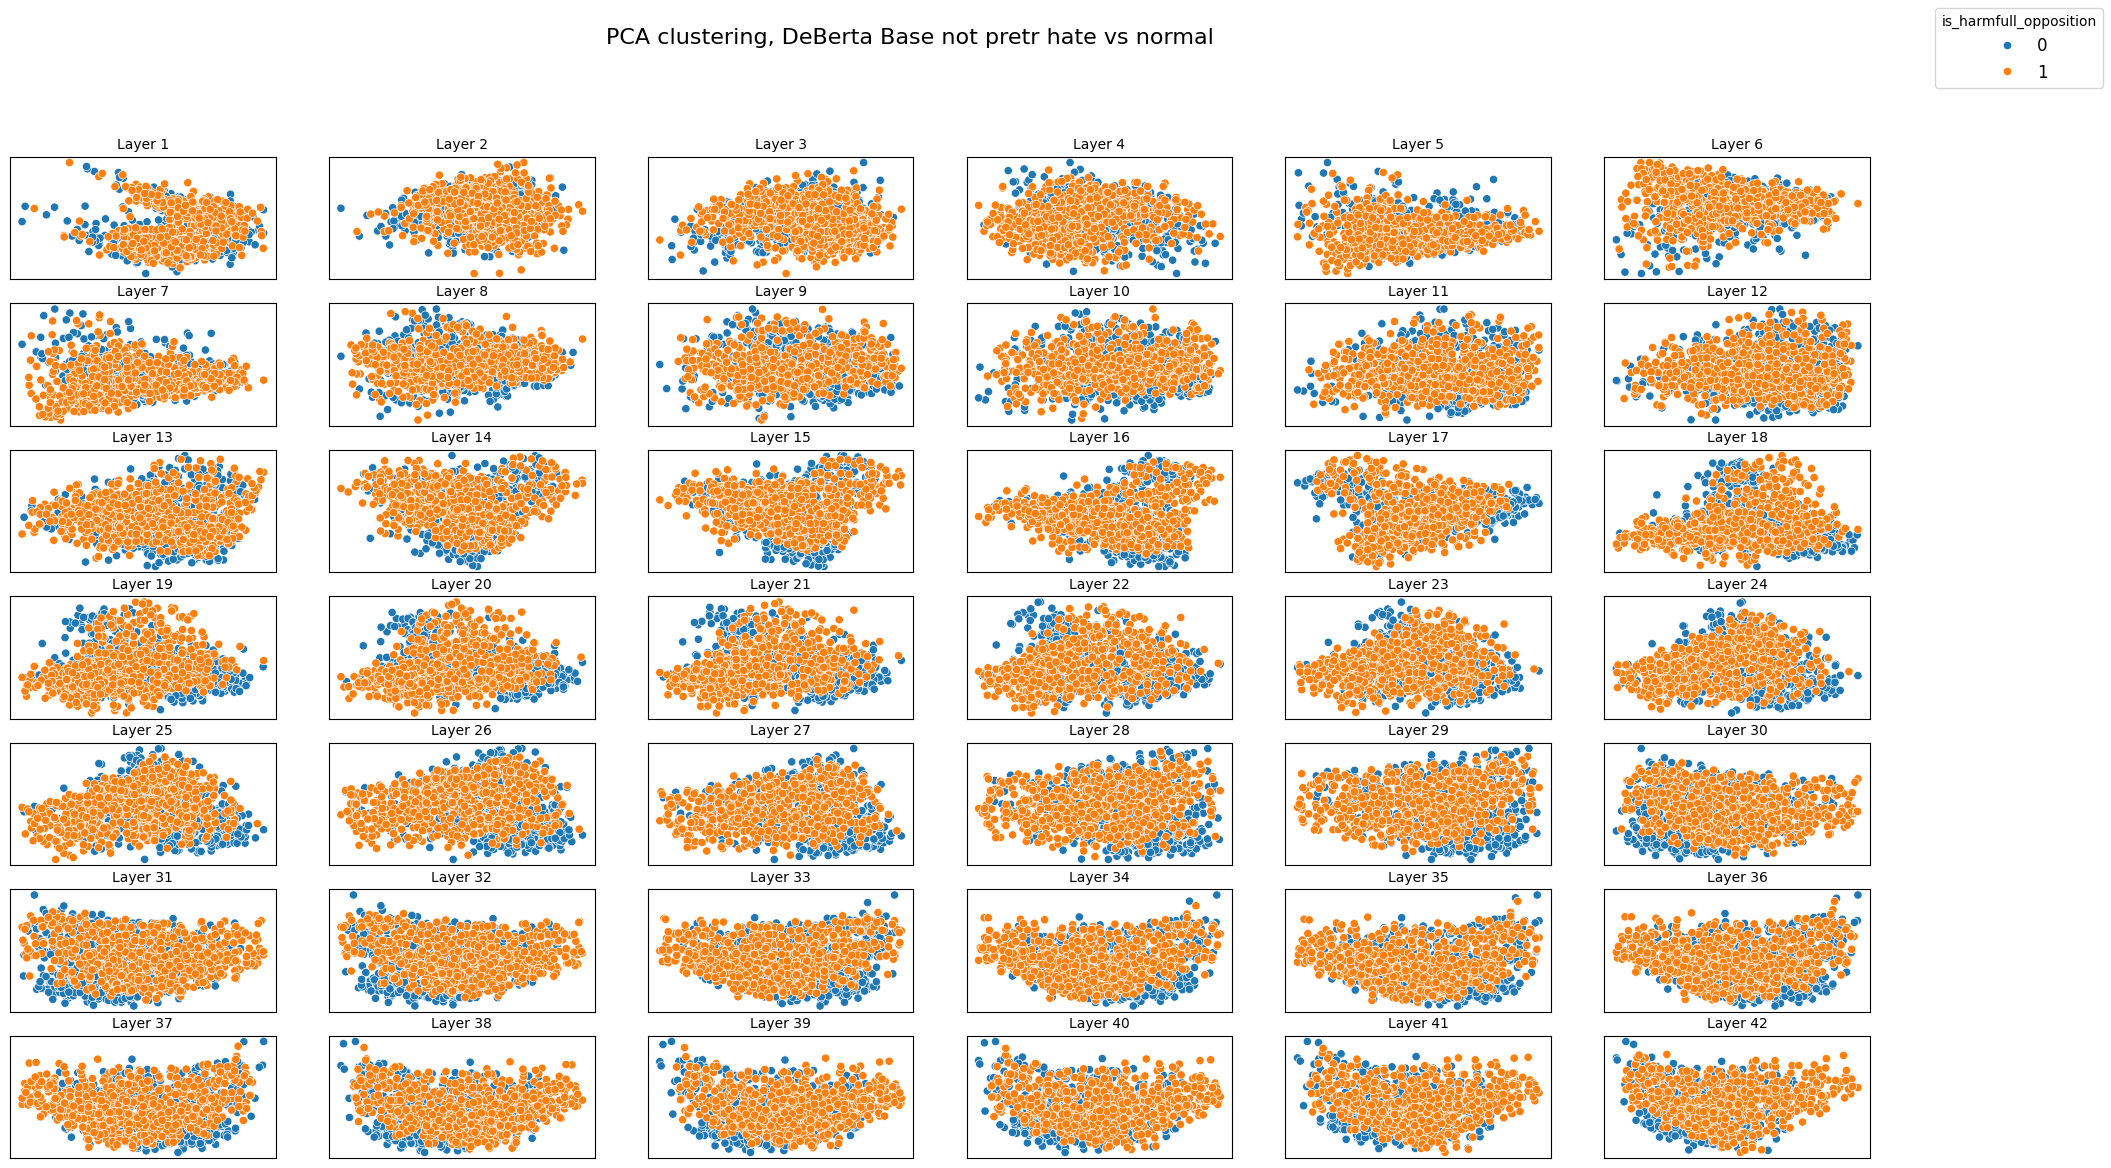

In [11]:
# path to big hate data
# path to big hate data
hate_data = pd.read_csv('../data/raw/total_hate3.0.csv', index_col=0)
hate_data.head(2)

hate_total_yes_data = pd.read_csv('../data/yes_no/hate_total3.0_yes.csv', index_col=0)
hate_total_no_data =  pd.read_csv('../data/yes_no/hate_total3.0_no.csv', index_col=0)

hate_total_yes_data['statement'] = hate_total_yes_data['statement'].apply(
                                    lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))
hate_total_no_data['statement'] = hate_total_no_data['statement'].apply(
                                        lambda x: x.replace('not', 'ttt').replace('Not', 'ttt'))


from extract import vectorize_df, extract_representation

X_pos = vectorize_df(hate_total_yes_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

X_neg = vectorize_df(hate_total_no_data['statement'],
                     gemma_model,
                     gemma_tokenizer,
                     layer_index=None,
                     strategy="last-token",      # CHANGED: Use last-token for decoder
                     model_type='decoder',       # CHANGED: Gemma is decoder, not encoder
                     use_decoder=False,          # CHANGED: Not needed for decoder-only
                     get_all_hs=True,
                     device=None)

np.savez_compressed(f'{YOUR_NAME}_neg_ttt.npz', X_neg)
np.savez_compressed(f'{YOUR_NAME}_pos_ttt.npz', X_pos)

# Load the files correctly
X_pos_file = np.load(f'{YOUR_NAME}_pos_ttt.npz')
X_neg_file = np.load(f'{YOUR_NAME}_neg_ttt.npz')

# Extract the actual arrays
X_pos = X_pos_file['arr_0']
X_neg = X_neg_file['arr_0']


# Check data types and shapes first
print("X_pos dtype:", X_pos.dtype)
print("X_pos shape:", X_pos.shape)
print("X_neg dtype:", X_neg.dtype)
print("X_neg shape:", X_neg.shape)

print("######################################################################################## ")
print("X_pos.max()", X_pos.max())
print("X_pos.min()", X_pos.min())
print("X_pos.mean()", X_pos.mean())
print("X_pos.std()", X_pos.std())
print("X_pos.median()", np.median(X_pos))
print("X_neg.max()", X_neg.max())
print("X_neg.min()", X_neg.min())
print("X_neg.mean()", X_neg.mean())
print("X_neg.std()", X_neg.std())
print("X_neg.median()", np.median(X_neg))
print("######################################################################################## ")

# Check for any issues with the data
print("X_pos sample:", X_pos.flat[:5])
print("X_neg sample:", X_neg.flat[:5])

# Convert to proper numeric type if needed
X_pos = X_pos.astype(np.float32)
X_neg = X_neg.astype(np.float32)

n_samples, n_layers, n_features = X_pos.shape

# Normalize the data
X_pos_normalized = X_pos.reshape(-1, X_pos.shape[-1])         # (512*25, 768)
X_pos_normalized = normalize(X_pos_normalized, norm='l2', axis=1).reshape(X_pos.shape)

X_neg_normalized = X_neg.reshape(-1, X_neg.shape[-1])         # (512*25, 768)
X_neg_normalized = normalize(X_neg_normalized, norm='l2', axis=1).reshape(X_neg.shape)

print("Normalization completed!")
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized shape:", X_neg_normalized.shape)

# Check data types and shapes first
print("X_pos_normalized dtype:", X_pos_normalized.dtype)
print("X_pos_normalized shape:", X_pos_normalized.shape)
print("X_neg_normalized dtype:", X_neg_normalized.dtype)
print("X_neg_normalized shape:", X_neg_normalized.shape)

print("######################################################################################## ")
print("X_pos_normalized.max()", X_pos_normalized.max())
print("X_pos_normalized.min()", X_pos_normalized.min())
print("X_pos_normalized.mean()", X_pos_normalized.mean())
print("X_pos_normalized.std()", X_pos_normalized.std())
print("X_pos_normalized.median()", np.median(X_pos_normalized))
print("X_neg_normalized.max()", X_neg_normalized.max())
print("X_neg_normalized.min()", X_neg_normalized.min())
print("X_neg_normalized.mean()", X_neg_normalized.mean())
print("X_neg_normalized.std()", X_neg_normalized.std())
print("X_neg_normalized.median()", np.median(X_neg_normalized))
print("######################################################################################## ")

# Verify normalization worked - check L2 norms
print("X_pos_normalized sample norms:", np.linalg.norm(X_pos_normalized.reshape(-1, n_features)[:5], axis=1))
print("X_neg_normalized sample norms:", np.linalg.norm(X_neg_normalized.reshape(-1, n_features)[:5], axis=1))

# Plot PCA
from format_results_fixed import plot_pca_or_tsne_layerwise
plot_pca_or_tsne_layerwise(X_pos_normalized,
                           X_neg_normalized,
                           hate_data['is_harmfull_opposition'],
                           standardize=False, n_components=5,
                           components=[0, 1], mode='pca',
                           plot_title='PCA clustering, DeBerta Base not pretr hate vs normal')




In [12]:
from ccs import CCS, train_ccs_on_hidden_states
from sklearn.model_selection import train_test_split
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Train-test indexes (for all experiments)
idx = np.arange(len(X_pos_normalized))
train_idx, test_idx = train_test_split(idx, test_size=0.15, random_state=71, shuffle=True)


# train CCS on normalized states
orig_ccs = train_ccs_on_hidden_states(X_pos_normalized,
                                        X_neg_normalized,
                                        hate_data['is_harmfull_opposition'],
                                         train_idx,
                                         test_idx,
                                        normalizing='median')
with open(f'ccs_{YOUR_NAME}_ttt_data_results.pkl', 'wb') as f:
    pickle.dump(orig_ccs, f)
    


Median normalize used
Layer 1/43, CCS accuracy: 0.5478723404255319
Median normalize used
Layer 2/43, CCS accuracy: 0.5159574468085106
Median normalize used
Layer 3/43, CCS accuracy: 0.5585106382978723
Median normalize used
Layer 4/43, CCS accuracy: 0.5638297872340425
Median normalize used
Layer 5/43, CCS accuracy: 0.5797872340425532
Median normalize used
Layer 6/43, CCS accuracy: 0.5531914893617021
Median normalize used
Layer 7/43, CCS accuracy: 0.5531914893617021
Median normalize used
Layer 8/43, CCS accuracy: 0.5691489361702128
Median normalize used
Layer 9/43, CCS accuracy: 0.5638297872340425
Median normalize used
Layer 10/43, CCS accuracy: 0.6063829787234043
Median normalize used
Layer 11/43, CCS accuracy: 0.6063829787234043
Median normalize used
Layer 12/43, CCS accuracy: 0.5904255319148937
Median normalize used
Layer 13/43, CCS accuracy: 0.5691489361702128
Median normalize used
Layer 14/43, CCS accuracy: 0.574468085106383
Median normalize used
Layer 15/43, CCS accuracy: 0.6010638

In [13]:
from ccs import CCS
import random

X_pos_normalized_data = pd.DataFrame(X_pos_normalized[:, LAYER_IDX])
X_neg_normalized_data = pd.DataFrame(X_neg_normalized[:, LAYER_IDX])


# Train-Test indexes
X_pos_norm_train = X_pos_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_pos_norm_test  = X_pos_normalized_data.loc[test_idx, :].values.astype(np.float32)

X_neg_norm_train = X_neg_normalized_data.loc[train_idx, :].values.astype(np.float32)
X_neg_norm_test  = X_neg_normalized_data.loc[test_idx, :].values.astype(np.float32)

y_train = hate_data['is_harmfull_opposition'][train_idx]
y_test  = hate_data['is_harmfull_opposition'][test_idx]

# Median normalizing
X_pos_norm_train -= np.median(X_pos_norm_train)
X_pos_norm_test -= np.median(X_pos_norm_train)

X_neg_norm_train -= np.median(X_neg_norm_train)
X_neg_norm_test -= np.median(X_neg_norm_train)

# Train CCS without labels first NEG, after POS!
ccs = CCS(X_neg_norm_train, X_pos_norm_train, y_train.values, var_normalize=False, lambda_classification=0, predict_normalize=False)
ccs.repeated_train()

# Evaluate
ccs_acc = ccs.get_acc(X_neg_norm_test, X_pos_norm_test, y_test.values)
print("CCS accuracy: {}".format(ccs_acc))

CCS accuracy: 0.6117021276595744


## **7. Plot results tables.**

In [14]:
from format_results import get_results_table
orig_ccs_data = get_results_table(orig_ccs)

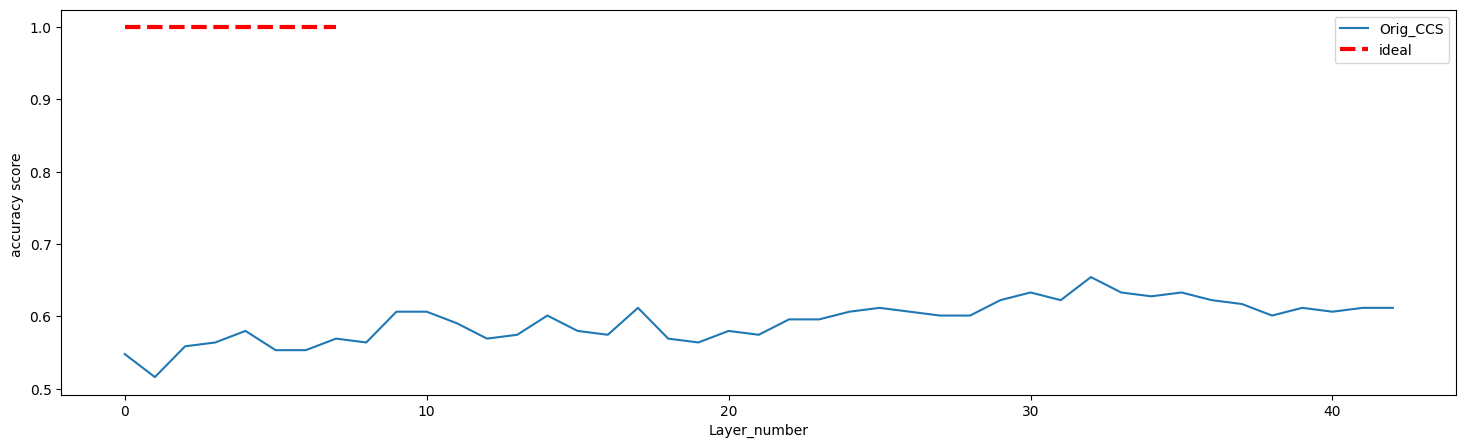

In [15]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['accuracy'], label='Orig_CCS')

plt.hlines(1, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('accuracy score ')
plt.legend(loc='upper right');

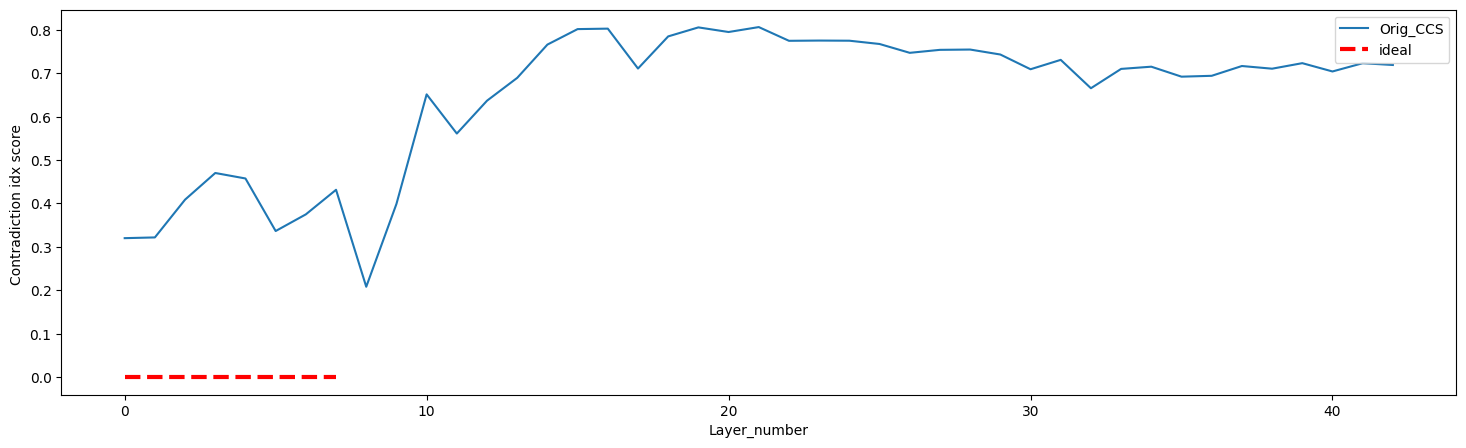

In [16]:
from format_results import get_results_table
orig_ccs_data = get_results_table(orig_ccs)

fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['contradiction idx ↓'], label='Orig_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Contradiction idx score ')
plt.legend(loc='upper right');

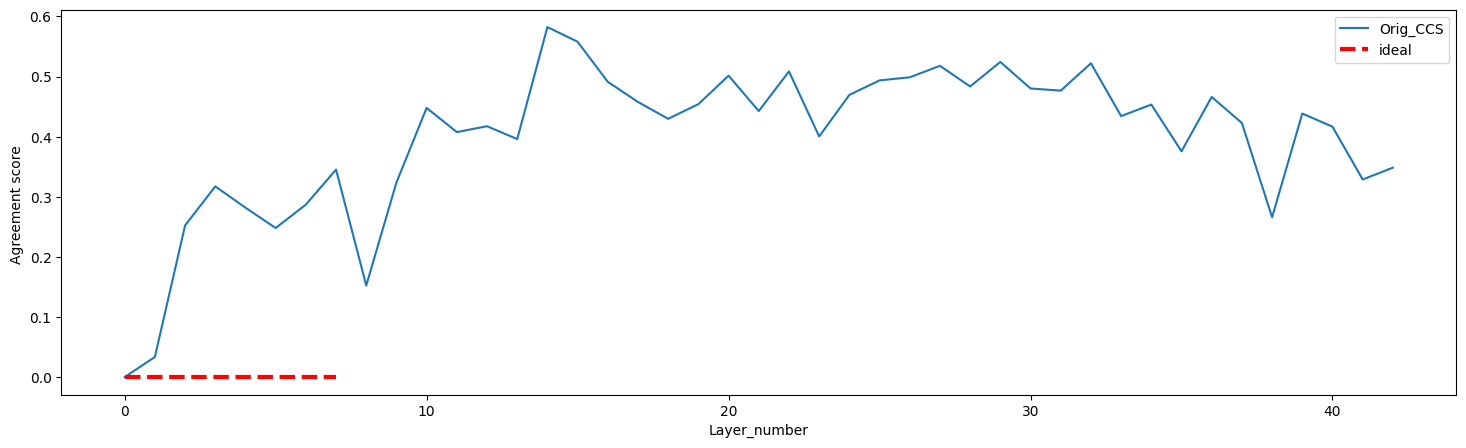

In [17]:
fig, ax = plt.subplots(figsize=(18, 5))

plt.plot(orig_ccs_data['agreement_score ↓'], label='Orig_CCS')

plt.hlines(0, 0, 7, label='ideal', colors='red', linewidth=3, linestyles=['--'])

plt.xlabel('Layer_number')
plt.ylabel('Agreement score ')
plt.legend(loc='upper right');